<a href="https://colab.research.google.com/github/arezekhanari/FCV-project/blob/main/FCV_PRJ.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Based on Nuscenes Tutorial
You can see the original tutorial by onening this notebook.
<br>
<a href="https://colab.research.google.com/github/nutonomy/nuscenes-devkit/blob/master/python-sdk/tutorials/nuscenes_tutorial.ipynb">
    <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab" align="left">
</a>
<br>


# Load the Dataset

In [ ]:
!mkdir -p /data/sets/nuscenes  # Make the directory to store the nuScenes dataset in.

!wget https://www.nuscenes.org/data/v1.0-mini.tgz  # Download the nuScenes mini split.

!tar -xf v1.0-mini.tgz -C /data/sets/nuscenes  # Uncompress the nuScenes mini split.

!pip install nuscenes-devkit &> /dev/null  # Install nuScenes.

--2024-02-06 16:52:09--  https://www.nuscenes.org/data/v1.0-mini.tgz
Resolving www.nuscenes.org (www.nuscenes.org)... 99.84.203.29, 99.84.203.77, 99.84.203.117, ...
Connecting to www.nuscenes.org (www.nuscenes.org)|99.84.203.29|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4167696325 (3.9G) [application/x-tar]
Saving to: ‘v1.0-mini.tgz’

v1.0-mini.tgz       100%[===================>]   3.88G  65.5MB/s    in 58s     

2024-02-06 16:53:07 (68.7 MB/s) - ‘v1.0-mini.tgz’ saved [4167696325/4167696325]



# Imports and Initialization

In [ ]:
import numpy as np
import cv2
from matplotlib import pyplot as plt
%matplotlib inline
import imageio
from nuscenes.nuscenes import NuScenes
import os
nusc = NuScenes(version='v1.0-mini', dataroot='/data/sets/nuscenes', verbose=True)

Loading NuScenes tables for version v1.0-mini...
23 category,
8 attribute,
4 visibility,
911 instance,
12 sensor,
120 calibrated_sensor,
31206 ego_pose,
8 log,
10 scene,
404 sample,
31206 sample_data,
18538 sample_annotation,
4 map,
Done loading in 1.703 seconds.
Reverse indexing ...
Done reverse indexing in 0.6 seconds.


# Image Stitching

First we write a function to compute the homography matrix. We only need to run this function once in every example, as the homography matrix is shared between different frames, which is a good thing because this step could be somewhat time consuming for our application.

In [ ]:
def estimate_homography(img1, img2, reprojThreshold=5.0, good_rate=0.7):
  # 1. Detect the keypoints and compute the descriptors
  sift = cv2.SIFT_create()
  keypoints1, des1 = sift.detectAndCompute(img1, None)
  keypoints2, des2 = sift.detectAndCompute(img2, None)
  # 2. Match the keypoints
  bf = cv2.BFMatcher(cv2.NORM_L2)
  matches = bf.knnMatch(des1, des2, k=2)
  # Apply ratio test to select good matches
  good_matches, good_points = [], [[0, 0] for i in range(len(matches))]
  for i, (m, n) in enumerate(matches):
      if m.distance < good_rate * n.distance:
          good_matches.append(m)
          good_points[i] = [1, 0]
  pts1 = np.float32([keypoints1[m.queryIdx].pt for m in good_matches]).reshape(-1, 1, 2)
  pts2 = np.float32([keypoints2[m.trainIdx].pt for m in good_matches]).reshape(-1, 1, 2)
  # 3. Calculate the homographic matrix
  (H, status) = cv2.findHomography(pts1, pts2, cv2.RANSAC, reprojThreshold)

  return H


Next we write a functino to stitch images from the same frame. We run this function for every pair of images available in each example.

In [ ]:
def stitch(img1, img2, H):
  # 4. Warp the image
  warped_image1 = cv2.warpPerspective(img1, H, (img1.shape[1] + img2.shape[1], img1.shape[0]))
  warped_image1[0 : img2.shape[0], 0 : img2.shape[1]] = img2
  blend_image = warped_image1
  return blend_image

In [ ]:
rear = cv2.imread('/data/sets/nuscenes/samples/CAM_BACK/n008-2018-08-01-15-16-36-0400__CAM_BACK__1533151603537558.jpg')
r_left = cv2.imread('/data/sets/nuscenes/samples/CAM_BACK_LEFT/n008-2018-08-01-15-16-36-0400__CAM_BACK_LEFT__1533151603547405.jpg')
r_right = cv2.imread('/data/sets/nuscenes/samples/CAM_BACK_RIGHT/n008-2018-08-01-15-16-36-0400__CAM_BACK_RIGHT__1533151603528113.jpg')
front = cv2.imread('/data/sets/nuscenes/samples/CAM_FRONT/n008-2018-08-01-15-16-36-0400__CAM_FRONT__1533151603512404.jpg')
f_left = cv2.imread('/data/sets/nuscenes/samples/CAM_FRONT_LEFT/n008-2018-08-01-15-16-36-0400__CAM_FRONT_LEFT__1533151603504799.jpg')
f_right = cv2.imread('/data/sets/nuscenes/samples/CAM_FRONT_RIGHT/n008-2018-08-01-15-16-36-0400__CAM_FRONT_RIGHT__1533151603520482.jpg')
rear = cv2.cvtColor(rear, cv2.COLOR_BGR2RGB)
r_left = cv2.cvtColor(r_left, cv2.COLOR_BGR2RGB)
r_right = cv2.cvtColor(r_right, cv2.COLOR_BGR2RGB)
front = cv2.cvtColor(front, cv2.COLOR_BGR2RGB)
f_left = cv2.cvtColor(f_left, cv2.COLOR_BGR2RGB)
f_right = cv2.cvtColor(f_right, cv2.COLOR_BGR2RGB)

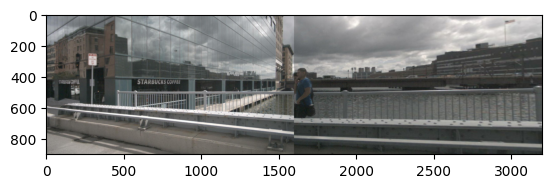

In [ ]:
h = estimate_homography(r_right, f_right)
b = stitch(r_right, f_right, h)
plt.imshow(b)

# Load Samples

In [ ]:
# @title some helper functions
def list_files(directory):
    files = []
    for root, _, filenames in os.walk(directory):
        for filename in filenames:
            files.append(os.path.join(root, filename))
    return sorted(files)

def load_images_from_folder(directory, day=True):
    files = list_files(directory)
    if day:
      files = files[:163]
    else:
      files = files[163:]
    images = []
    for filename in files:
        img = cv2.imread(filename)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        images.append(img)
    return images

def load_all_images(day=True):
    all_images = dict()
    all_images['CAM_BACK'] = load_images_from_folder('/data/sets/nuscenes/samples/CAM_BACK/')
    all_images['CAM_BACK_LEFT'] = load_images_from_folder('/data/sets/nuscenes/samples/CAM_BACK_LEFT/')
    all_images['CAM_BACK_RIGHT'] = load_images_from_folder('/data/sets/nuscenes/samples/CAM_BACK_RIGHT/')
    all_images['CAM_FRONT'] = load_images_from_folder('/data/sets/nuscenes/samples/CAM_FRONT/')
    all_images['CAM_FRONT_LEFT'] = load_images_from_folder('/data/sets/nuscenes/samples/CAM_FRONT_LEFT/')
    all_images['CAM_FRONT_RIGHT'] = load_images_from_folder('/data/sets/nuscenes/samples/CAM_FRONT_RIGHT/')
    return all_images

In [ ]:
images = load_all_images()

## Systematic stitching

In [ ]:
def start_stitching(images, gif_path='fl_bl_s.gif', resize=True, fps=20):
    # H_br_fr = estimate_homography(images['CAM_BACK_RIGHT'][0], images['CAM_FRONT_RIGHT'][0])
    H_fl_bl = estimate_homography(images['CAM_FRONT_LEFT'][0], images['CAM_BACK_LEFT'][0])
    gif_images = list()
    for i in range(163):
        # res = stitch(images['CAM_BACK_RIGHT'][i], images['CAM_FRONT_RIGHT'][i], H_br_fr)
        res = stitch(images['CAM_FRONT_LEFT'][i], images['CAM_BACK_LEFT'][i], H_fl_bl)
        if resize:
          res = cv2.resize(res, (800, 225))
        gif_images.append(res)
    imageio.mimsave(gif_path, gif_images, fps=fps)


In [ ]:
def start_stitching(images, gif_path='fl_bl_n2.gif', resize=True, fps=20):
    # H_br_fr = estimate_homography(images['CAM_BACK_RIGHT'][0], images['CAM_FRONT_RIGHT'][0])
    H_fl_bl_base = estimate_homography(images['CAM_FRONT_LEFT'][0], images['CAM_BACK_LEFT'][0])
    gif_images = list()
    cntr = 0
    for i in range(130):
        # res = stitch(images['CAM_BACK_RIGHT'][i], images['CAM_FRONT_RIGHT'][i], H_br_fr)
        H_fl_bl = estimate_homography(images['CAM_FRONT_LEFT'][i], images['CAM_BACK_LEFT'][i])
        error = np.linalg.norm((H_fl_bl_base - H_fl_bl) ** 2)
        print(i, np.linalg.norm(H_fl_bl_base - H_fl_bl))
        if error > 100:
            H_fl_bl = H_fl_bl_base
        else:
          cntr += 1
          alpha = 1 / (cntr)
          H_fl_bl_base = alpha * H_fl_bl + (1 - alpha) * H_fl_bl_base
        res = stitch(images['CAM_FRONT_LEFT'][i], images['CAM_BACK_LEFT'][i], H_fl_bl)
        if resize:
          res = cv2.resize(res, (800, 225))
        gif_images.append(res)
    imageio.mimsave(gif_path, gif_images, fps=fps)

In [ ]:
start_stitching(images)

0 0.0
1 19.906021977776884
2 31.193557826215855
3 11.431290419026165
4 16.94069621369394
5 16.239459946364594
6 16.235193763296802
7 7.897248552060266
8 16.599003295434624
9 17.578351660688188
10 10.477169013548632
11 11.1914751540951
12 9.056803601105996
13 129.343461040738
14 23.874611119436466
15 27.778064688403916
16 25.53555068623353
17 15.502030552143175
18 65.15347587617279
19 31.402975655931307
20 26.645466477023366
21 30.45389296439826
22 66.81214073218516
23 21.077066162182703
24 53.084589239571656
25 11.494251961966548
26 14.760154969765194
27 29.738503751184492
28 10.564393103794792
29 12.153949973686563
30 2.4231892959006696
31 17.31460968813374
32 13.17034200076357
33 6.7869551600478015
34 33.62108356922076
35 12.977570395128797
36 5.495187310888173
37 10.865265714098262
38 7.928046978596728
39 9.849364075966971
40 2.942275423919595
41 62.56983953285627
42 35.908269320861294
43 15.37949648100583
44 14.880633584816902
45 3.183257994656255
46 13.996245397890066
47 517.55754

In [ ]:
def start_stitching(images, gif_path='_bl.gif', resize=True, fps=20):
    # H_br_fr = estimate_homography(images['CAM_BACK_RIGHT'][0], images['CAM_FRONT_RIGHT'][0])
    H_fl_bl_base = estimate_homography(images['CAM_FRONT_LEFT'][0], images['CAM_BACK_LEFT'][0])
    gif_images = list()
    cntr = 0
    for i in range(130):
        # res = stitch(images['CAM_BACK_RIGHT'][i], images['CAM_FRONT_RIGHT'][i], H_br_fr)
        H_fl_bl = estimate_homography(images['CAM_FRONT_LEFT'][i], images['CAM_BACK_LEFT'][i])
        error = np.linalg.norm((H_fl_bl_base - H_fl_bl) ** 2)
        print(i, np.linalg.norm(H_fl_bl_base - H_fl_bl))
        if error > 100:
            H_fl_bl = H_fl_bl_base
        else:
          cntr += 1
          alpha = 1 / (cntr)
          H_fl_bl_base = alpha * H_fl_bl + (1 - alpha) * H_fl_bl_base
        res = stitch(images['CAM_FRONT_LEFT'][i], images['CAM_BACK_LEFT'][i], H_fl_bl)
        if resize:
          res = cv2.resize(res, (800, 225))
        gif_images.append(res)
    imageio.mimsave(gif_path, gif_images, fps=fps)

In [ ]:
from IPython.display import Image

# URL of the GIF
gif_url = "/content/fl_bl.gif"  # Replace with the URL of your GIF
Image(gif_url)

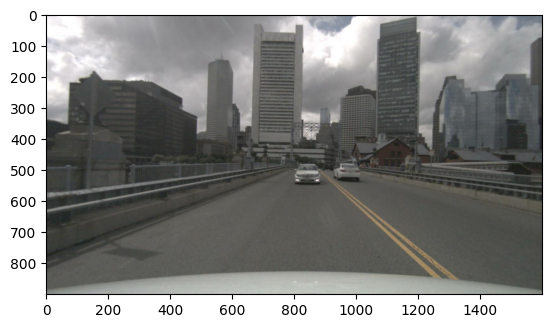

In [ ]:
plt.imshow(q[0])

In [ ]:
images

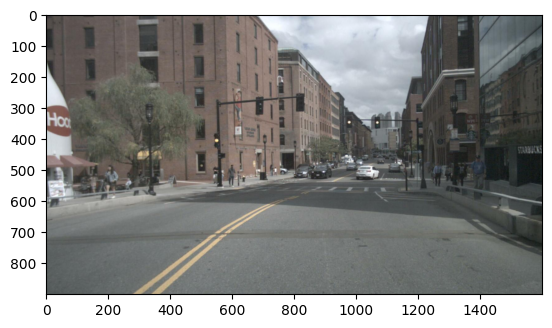

In [ ]:
plt.imshow(images['CAM_FRONT'][0])

In [ ]:
def stich(image1, image2):
  # Convert images to grayscale
  # gray1 = cv2.cvtColor(image1, cv2.COLOR_BGR2GRAY)
  # gray2 = cv2.cvtColor(image2, cv2.COLOR_BGR2GRAY)

  # Find keypoints and descriptors using ORB
  sift = cv2.SIFT_create()
  keypoints1, descriptors1 = sift.detectAndCompute(image1, None)
  keypoints2, descriptors2 = sift.detectAndCompute(image2, None)

  # Match keypoints using Brute-Force Matcher
  bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
  matches = bf.match(descriptors1, descriptors2)

  # Sort matches by distance
  matches = sorted(matches, key=lambda x: x.distance)

  # Extract matched keypoints
  points1 = np.float32([keypoints1[m.queryIdx].pt for m in matches]).reshape(-1, 1, 2)
  points2 = np.float32([keypoints2[m.trainIdx].pt for m in matches]).reshape(-1, 1, 2)

  # Compute homography matrix
  H, _ = cv2.findHomography(points1, points2, cv2.RANSAC)

  # Warp image1 to image2
  height, width, _ = image2.shape
  warped_image1 = cv2.warpPerspective(image1, H, (width, height))

  # Blend images
  blend_image = cv2.addWeighted(warped_image1, 0.5, image2, 0.5, 0)

  return blend_image

In [ ]:
def merge(img1_orig, img2_orig, reprojThreshold=5.0, good_rate=0.7):
  # 1. Detect the keypoints and compute the descriptors
  sift = cv2.SIFT_create()
  keypoints1, des1 = sift.detectAndCompute(img1_orig, None)
  keypoints2, des2 = sift.detectAndCompute(img2_orig, None)
  # 2. Match the keypoints
  bf = cv2.BFMatcher(cv2.NORM_L2)
  matches = bf.knnMatch(des1, des2, k=2)
  # Apply ratio test to select good matches
  good_matches, good_points = [], [[0, 0] for i in range(len(matches))]
  for i, (m, n) in enumerate(matches):
      if m.distance < good_rate * n.distance:
          good_matches.append(m)
          good_points[i] = [1, 0]
  pts1 = np.float32([keypoints1[m.queryIdx].pt for m in good_matches]).reshape(-1, 1, 2)
  pts2 = np.float32([keypoints2[m.trainIdx].pt for m in good_matches]).reshape(-1, 1, 2)
  # 3. Calculate the homographic matrix
  (H, status) = cv2.findHomography(pts1, pts2, cv2.RANSAC, reprojThreshold)
  # 4. Warp the image
  warped_image1 = cv2.warpPerspective(img1_orig, H, (img1_orig.shape[1] + img2_orig.shape[1], img1_orig.shape[0]))
  warped_image1[0 : img2_orig.shape[0], 0 : img2_orig.shape[1]] = img2_orig
  # Warp image1 to image2
  # height, width, _ = img2_orig.shape
  # warped_image1 = cv2.warpPerspective(img1_orig, H, (width, height))
  # # Remove black margins
  # i = 0
  # while np.count_nonzero(warped_image1[:, i]) == 0:
  #   i += 1
  # # Blend images
  # print(warped_image1.shape, img2_orig.shape, i)
  # blend_image = cv2.addWeighted(warped_image1[:, 1600:], 0.5, img2_orig, 0.5, 0)
  # blend_image = cv2.addWeighted(img2_orig, 0.5, warped_image1[:, i:], 0.5, 0)
  return warped_image1#[:, :-i], drawn
  # return warped_image1[:, i:]

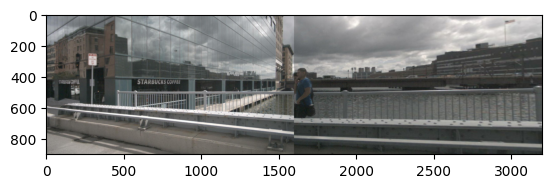

In [ ]:
b = merge(r_right, f_right)
plt.imshow(b)

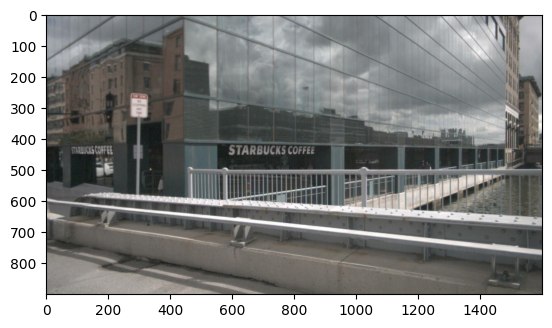

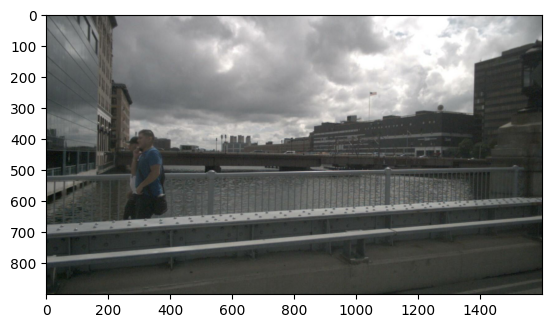

In [ ]:
plt.imshow(f_right)
plt.show()
plt.imshow(r_right)
plt.show()

In [ ]:
plt.subplot()

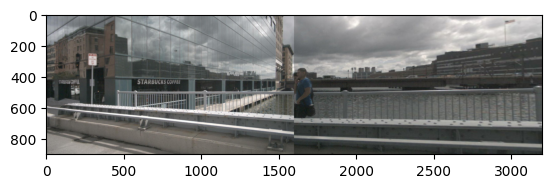

In [ ]:
b = merge(r_right, f_right)
plt.imshow(b)

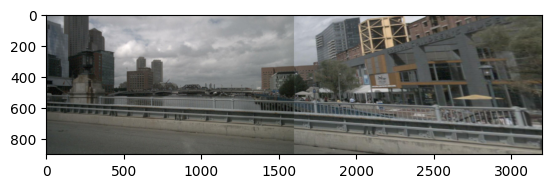

In [ ]:
b = merge(f_left, r_left)
plt.imshow(b)

In [ ]:
r_left.shape

(900, 1600, 3)

In [ ]:
a = merge(f_left, r_left)
plt.imshow(a)

(900, 3200, 3) (900, 1600, 3) 1294


NameError: name 'plt' is not defined

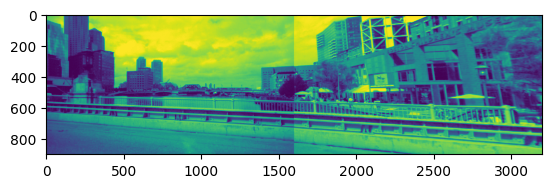

In [ ]:
# Convert the image to grayscale
gray = cv2.cvtColor(a, cv2.COLOR_BGR2GRAY)

# Apply histogram equalization
equalized = cv2.equalizeHist(gray)

# Display the result
plt.imshow(equalized)

In [ ]:
1600+1327

2927

In [ ]:
f = merge(f_right, front)
plt.imshow(f)

(900, 3200, 3) (900, 1600, 3) 0


NameError: name 'plt' is not defined

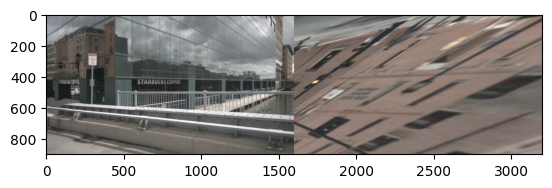

In [ ]:
plt.imshow(f)

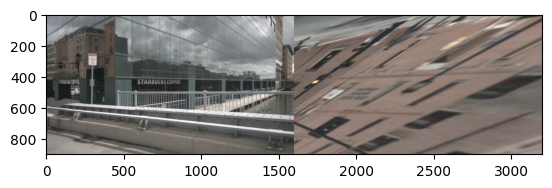

In [ ]:
f = merge(front, f_right)
plt.imshow(f)



*   List item
*   List item



(900, 3200, 3) (900, 1600, 3) 1327
(900, 3200, 3) (900, 3200, 3)
(900, 2927, 3)


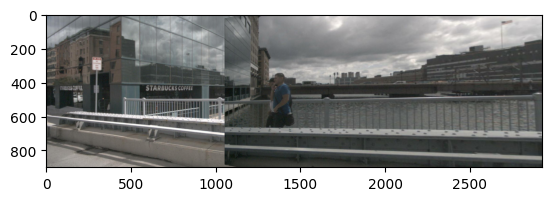

In [ ]:
w = merge(img1, img2)
x = np.zeros_like(w)
x[:, :1600] = img2
print(w.shape, x.shape)
w = w[:, 273:]
x = x[:, :-273]
o = blend_images(w, x)
plt.imshow(o)

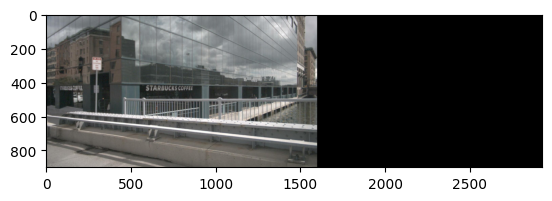

In [ ]:
plt.imshow(x[:, :-273])

In [ ]:
1600-1327

273

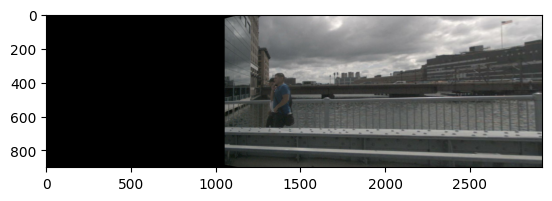

In [ ]:
plt.imshow(w[:, 273:])

In [ ]:
img1, img2 = r_right, f_right
output_img = stiched(img1, img2)
plt.imshow(output_img)

(3978, 11513, 3)


ValueError: operands could not be broadcast together with shapes (900,1600,3) (3978,11513,3) 

In [ ]:
def detect_and_match_features(img1, img2):
    orb = cv2.ORB_create()
    keypoints1, descriptors1 = orb.detectAndCompute(img1, None)
    keypoints2, descriptors2 = orb.detectAndCompute(img2, None)

    bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
    matches = bf.match(descriptors1, descriptors2)
    matches = sorted(matches, key=lambda x: x.distance)

    return keypoints1, keypoints2, matches

def estimate_homography(keypoints1, keypoints2, matches, threshold=3):
    src_points = np.float32([keypoints1[m.queryIdx].pt for m in matches]).reshape(-1, 1, 2)
    dst_points = np.float32([keypoints2[m.trainIdx].pt for m in matches]).reshape(-1, 1, 2)

    H, mask = cv2.findHomography(src_points, dst_points, cv2.RANSAC, threshold)
    return H, mask

def warp_images(img1, img2, H):
    h1, w1 = img1.shape[:2]
    h2, w2 = img2.shape[:2]

    corners1 = np.float32([[0, 0], [0, h1], [w1, h1], [w1, 0]]).reshape(-1, 1, 2)
    corners2 = np.float32([[0, 0], [0, h2], [w2, h2], [w2, 0]]).reshape(-1, 1, 2)
    warped_corners2 = cv2.perspectiveTransform(corners2, H)

    corners = np.concatenate((corners1, warped_corners2), axis=0)
    [xmin, ymin] = np.int32(corners.min(axis=0).ravel() - 0.5)
    [xmax, ymax] = np.int32(corners.max(axis=0).ravel() + 0.5)

    t = [-xmin, -ymin]
    Ht = np.array([[1, 0, t[0]], [0, 1, t[1]], [0, 0, 1]])

    warped_img2 = cv2.warpPerspective(img2, Ht @ H, (xmax - xmin, ymax - ymin))
    warped_img2[t[1]:h1 + t[1], t[0]:w1 + t[0]] = img1

    return warped_img2

def blend_images(img1, img2):
    mask = np.where(img1 != 0, 1, 0).astype(np.float32)
    print(mask.shape)
    blended_img = img1 * mask + img2 * (1 - mask)
    return blended_img.astype(np.uint8)

def stiched(img1, img2):
  keypoints1, keypoints2, matches = detect_and_match_features(img1, img2)
  H, mask = estimate_homography(keypoints1, keypoints2, matches)
  warped_img = warp_images(img1, img2, H)
  output_img = blend_images(warped_img, img1)
  return output_img

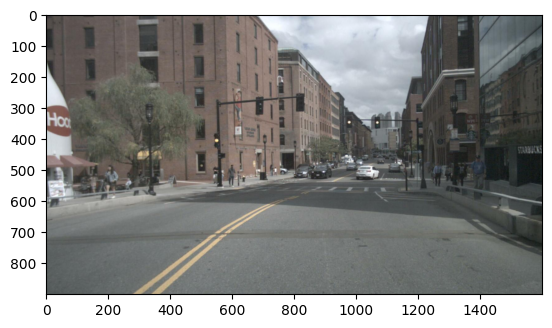